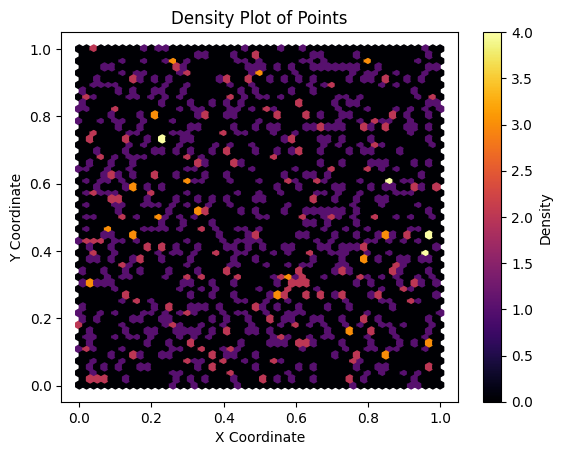

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Generating random data
data = np.random.rand(1000, 2)
df = pd.DataFrame(data, columns=['X', 'Y'])

# Creating a hexbin plot
fig, ax = plt.subplots()
hb = ax.hexbin(df['X'], df['Y'], gridsize=50, cmap='inferno')

# Adding a color bar
cb = plt.colorbar(hb, ax=ax)
cb.set_label('Density')

# Adding labels and title
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
plt.title('Density Plot of Points')

plt.show()
